Step 1

In [1]:
import pandas as pd
import numpy as np

opt = pd.read_csv("option20230201_20230228.csv")
b_opt = opt.copy()

# converting dates
opt["date"] = pd.to_datetime(opt["date"], errors="coerce")
opt["exdate"] = pd.to_datetime(opt["exdate"], errors="coerce")

# calls only 
rows_before = len(opt) # before filtering

opt["cp_flag"] = opt["cp_flag"].astype(str).str.strip().str.upper()
opt = opt[opt["cp_flag"] == "C"]
rows_after = len(opt)

# rescale strike
opt["strike_price"] = pd.to_numeric(opt["strike_price"]) / 1000.0

# midquote
opt["best_bid"] = pd.to_numeric(opt["best_bid"])
opt["best_offer"] = pd.to_numeric(opt["best_offer"])
opt["Vt"] = (opt["best_bid"]+opt["best_offer"])/2

# implied volatility
opt["impl_volatility"] = pd.to_numeric(opt["impl_volatility"])

rows_before_iv = len(opt)
opt = opt[opt["impl_volatility"].notna() & (opt["impl_volatility"] > 0)]
rows_after_iv = len(opt)

print("Rows before IV filter:", rows_before_iv)
print("Rows after IV filter:", rows_after_iv)

## Required reporting

print("Rows before call filter:", rows_before)
print("Rows after call filter:",rows_after)

# number of unique trading dates
unique_date = opt["date"].unique()
print("Number of unique trading dates:", len(unique_date))

# number of unique expiries
unique_expiries = opt["exdate"].unique()
print("Number of unique expiries:", len(unique_expiries))

# missing rates before filter
b_opt["best_bid"] = pd.to_numeric(b_opt["best_bid"])
b_opt["best_offer"] = pd.to_numeric(b_opt["best_offer"])
b_opt["Vt"] = (b_opt["best_bid"]+b_opt["best_offer"])/2
missing_rate_Vt_b = b_opt["Vt"].isna().mean()
missing_rate_sigma_b = b_opt["impl_volatility"].isna().mean()
missing_rate_delta_b = b_opt["delta"].isna().mean()
print("Missing rate before filter:")
print("Vt: ", missing_rate_Vt_b)
print("sigma: ", missing_rate_sigma_b)
print("delta: ", missing_rate_delta_b)

# missing rates after filter
missing_rate_Vt = opt["Vt"].isna().mean()
missing_rate_sigma = opt["impl_volatility"].isna().mean()
missing_rate_delta = opt["delta"].isna().mean()
print("Missing rate after filter:")
print("Vt: ", missing_rate_Vt)
print("sigma: ", missing_rate_sigma)
print("delta: ", missing_rate_delta)
print("Filter succesfully removed the missing values")

print("Final columns kept:")
print(list(opt.columns))

Rows before IV filter: 175301
Rows after IV filter: 153728
Rows before call filter: 175301
Rows after call filter: 175301
Number of unique trading dates: 19
Number of unique expiries: 67
Missing rate before filter:
Vt:  0.0
sigma:  0.12306261801130627
delta:  0.12306261801130627
Missing rate after filter:
Vt:  0.0
sigma:  0.0
delta:  0.0
Filter succesfully removed the missing values
Final columns kept:
['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag', 'forward_price', 'expiry_indicator', 'root', 'suffix', 'cusip', 'ticker', 'sic', 'index_flag', 'exchange_d', 'class', 'issue_type', 'industry_group', 'issuer', 'div_convention', 'exercise_style', 'am_set_flag', 'Vt']


Step 2

In [2]:
opt2 = opt.copy()
opt2["cid"] = opt2["symbol"]

# sorting by date and cid
opt2 = opt2.sort_values(["cid", "date"])

# calculating dVt
opt2["Vt_next"] = opt2.groupby("cid")["Vt"].shift(-1)
opt2["dVt"] = opt2["Vt_next"] - opt2["Vt"]

# removing NaN
opt2 = opt2[opt2["dVt"].notna()].copy()

## required reporting
print("Number of contracts retained:", len(opt2["cid"].unique()))
print("\n Summary Vt:",opt2["Vt"].describe())
print("\n Summary dVt:",opt2["dVt"].describe())



Number of contracts retained: 11593

 Summary Vt: count    141619.000000
mean        430.754198
std         578.585187
min           0.025000
25%          36.400000
50%         206.450000
75%         600.850000
max        4022.700000
Name: Vt, dtype: float64

 Summary dVt: count    141619.000000
mean         -6.315655
std          27.128320
min        -170.300000
25%         -22.200000
50%          -2.150000
75%           5.100000
max          70.200000
Name: dVt, dtype: float64


Step 3

Merge coverage: 100.00% (141619/141619)

 Summary St:
count    141619.000000
mean       4085.065277
std          64.690452
min        3970.040000
25%        4012.320000
50%        4090.460000
75%        4136.480000
max        4179.760000
Name: St, dtype: float64

 Summary dSt:
count    141619.000000
mean         -8.476981
std          37.850399
min         -81.750000
25%         -42.280000
50%         -11.320000
75%          12.200000
max          60.550000
Name: dSt, dtype: float64


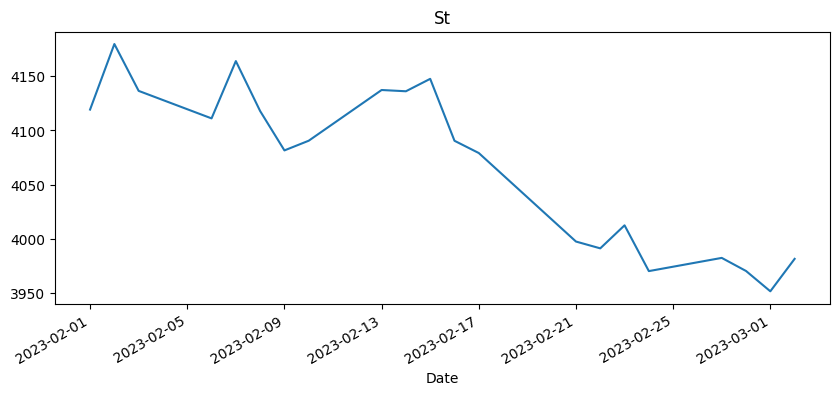

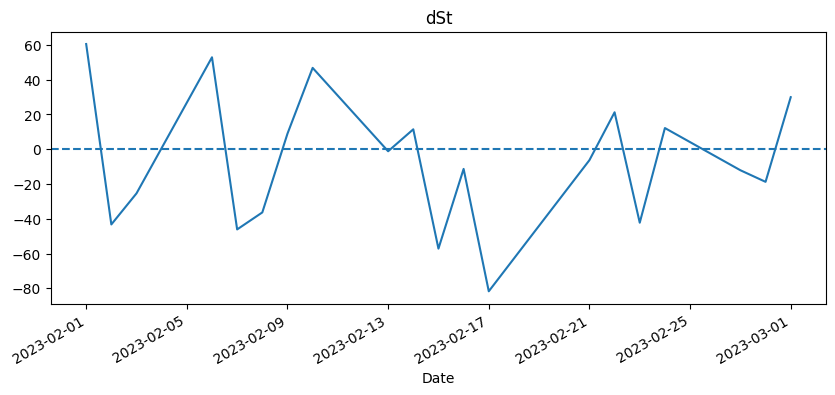

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

start = "2023-02-01"
end   = "2023-03-02"   # must include one extra day

d1 = pd.Timestamp(start).strftime("%Y%m%d")
d2 = pd.Timestamp(end).strftime("%Y%m%d")

url = f"https://stooq.com/q/d/l/?s=^spx&d1={d1}&d2={d2}&i=d"
df = pd.read_csv(url, parse_dates=["Date"]).sort_values("Date")

SPX_price_series = df.set_index("Date")["Close"]

# sorting
St= SPX_price_series.sort_index()

# calculating dSt
dSt = St.shift(-1) - St

# creating clean SPX dataframe
SPX_df = pd.DataFrame({
    "St": St,
    "dSt": dSt
}).dropna()

opt2["date"] = pd.to_datetime(opt2["date"]).dt.normalize()
SPX_df.index = SPX_df.index.normalize()
opt2 = opt2.drop(columns=["St", "dSt"], errors="ignore")

# merge
opt2 = opt2.merge(
    SPX_df,
    left_on="date",
    right_index=True,
    how="left"
)

rows_total = len(opt2)
matched = opt2[["St", "dSt"]].notna().all(axis=1).sum()

## required reporting
print(f"Merge coverage: {matched/rows_total*100:.2f}% ({matched}/{rows_total})")

print("\n Summary St:")
print(opt2["St"].describe())

print("\n Summary dSt:")
print(opt2["dSt"].describe())

plt.figure(figsize=(10,4))
St.plot()
plt.title("St")
plt.xlabel("Date")
plt.show()

plt.figure(figsize=(10,4))
dSt.plot()
plt.axhline(0, linestyle="--")
plt.title("dSt")
plt.xlabel("Date")
plt.show()


Step 4

In [4]:
import pandas as pd

url = (
    "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/"
    "daily-treasury-rate-archives/par-yield-curve-rates-2020-2023.csv"
)

treasury = pd.read_csv(url)
treasury = treasury.drop(columns=["4 mo"], errors="ignore")
treasury["date"] = pd.to_datetime(treasury["date"]).dt.normalize()

treasury.head()

,date,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0,2020-01-02,1.53,1.55,1.54,1.57,1.56,1.58,1.59,1.67,1.79,1.88,2.19,2.33
1,2020-01-03,1.52,1.55,1.52,1.55,1.55,1.53,1.54,1.59,1.71,1.80,2.11,2.26
2,2020-01-06,1.54,1.54,1.56,1.56,1.54,1.54,1.56,1.61,1.72,1.81,2.13,2.28
3,2020-01-07,1.52,1.53,1.54,1.56,1.53,1.54,1.55,1.62,1.74,1.83,2.16,2.31
4,2020-01-08,1.50,1.53,1.54,1.56,1.55,1.58,1.61,1.67,1.78,1.87,2.21,2.35


(a)

In [5]:
# one treasury curve per day
option_dates = opt2["date"].sort_values().unique()

# forward-fill
treasury = treasury.set_index("date").sort_index()
treasury_aligned = treasury.reindex(option_dates, method="ffill")
treasury_aligned.head()

,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
date,,,,,,,,,,,,
2023-02-01,4.59,4.63,4.66,4.79,4.66,4.09,3.75,3.48,3.43,3.39,3.67,3.55
2023-02-02,4.62,4.65,4.66,4.76,4.64,4.09,3.75,3.49,3.44,3.40,3.67,3.55
2023-02-03,4.61,4.67,4.70,4.82,4.79,4.30,3.96,3.67,3.61,3.53,3.77,3.63
2023-02-06,4.61,4.67,4.71,4.89,4.85,4.44,4.10,3.81,3.73,3.63,3.82,3.67
2023-02-07,4.62,4.68,4.71,4.89,4.88,4.47,4.11,3.85,3.78,3.67,3.87,3.72


(b)

In [6]:

# building functions for NSS curve

def g1(tau,lam):
    return (1-np.exp(-tau/lam))/(tau/lam)

def g2(tau,lam):
    return g1(tau,lam) - np.exp(-tau/lam)

def g3(tau,lam):
    return ((1-np.exp(-tau/lam))/(tau/lam)) - np.exp(-tau/lam)

def nss_yield(tau, beta0, beta1, beta2, beta3, tau1, tau2):
    return beta0 + beta1*g1(tau, tau1) + beta2*g2(tau, tau1) + beta3*g3(tau, tau2)



(c)

In [7]:

mj = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

# defining regressor matrix
def X(mj,tau1,tau2):
    X = np.column_stack([np.ones_like(mj), g1(mj,tau1), g2(mj,tau1), g3(mj,tau2)])
    return X

def y(t):
    return treasury_aligned.loc[t].values.astype(float)

# OLS
def OLS(X, y):
    return np.linalg.lstsq(X, y, rcond=None)[0]

# SSE
def SSE(X, y, beta):
    s = y - X @ beta
    return float(s @ s)

# grid search
tau1_grid = np.linspace(0.1, 5.0, 20)
tau2_grid = np.linspace(0.1, 10.0, 30)

rows = []

for t in treasury_aligned.index:
    yt = y(t)

    best_sse = np.inf
    best_beta = None
    best_tau1 = None
    best_tau2 = None

    for tau1 in tau1_grid:
        for tau2 in tau2_grid:
            if tau2 < tau1:
                continue

            Xmat = X(mj, tau1, tau2)
            beta = OLS(Xmat, yt)
            sse  = SSE(Xmat, yt, beta)

            if sse < best_sse:
                best_sse, best_beta, best_tau1, best_tau2 = sse, beta, tau1, tau2

    rows.append((t, *best_beta, best_tau1, best_tau2, best_sse))

nss_params = pd.DataFrame(
    rows,
    columns=["date","beta0","beta1","beta2","beta3","tau1","tau2","SSE"]
).set_index("date")

# fitted daily curve
def yhat(t, tau):
    
    p = nss_params.loc[t]
    b0, b1, b2, b3 = p["beta0"], p["beta1"], p["beta2"], p["beta3"]
    tau1, tau2     = p["tau1"],  p["tau2"]

    tau = np.asarray(tau, dtype=float)
    return b0 + b1*g1(tau, tau1) + b2*g2(tau, tau1) + b3*g3(tau, tau2)


(d)

In [8]:

#convert to decimals
def yhat_dec(t,tau):
    return yhat(t,tau)/100

opt2["tau"] = (opt2["exdate"] - opt2["date"]).dt.days / 365.0

# lower bound 
opt2["tau_safe"] = np.maximum(opt2["tau"], 1/365)

opt2["yhat"] = opt2.apply(
    lambda row: yhat_dec(row["date"], row["tau_safe"]),
    axis=1
)



(e)

Summary r:
min    0.034393
50%    0.046607
max    0.050690
Name: r, dtype: float64


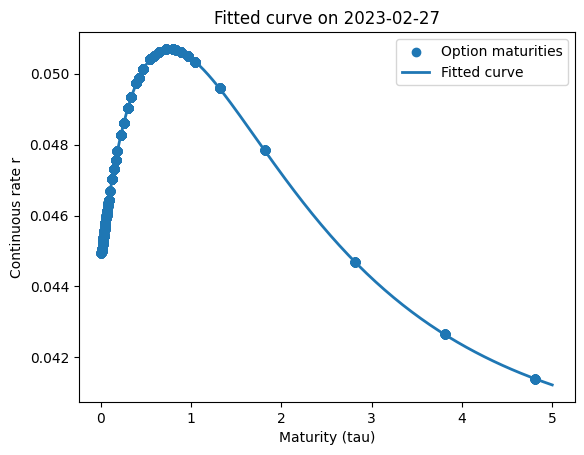

True
True


In [9]:

# rate
opt2["r"] = 2 * np.log(1 + opt2["yhat"] / 2)

# discount factor
opt2["P"] = np.exp(-opt2["r"]*opt2["tau_safe"])

# forward
q = 0
opt2["F"] = opt2["St"]*np.exp((opt2["r"]-q)*opt2["tau_safe"])

## required reporting 

# summary of r
print("Summary r:")
print(opt2["r"].describe()[["min", "50%", "max"]])

# one plot of fitted curve
rep_date = pd.Timestamp("2023-02-27")
subset = opt2[opt2["date"] == rep_date]

# grids
tau_grid = np.linspace(0.01, 5, 200)
r_grid = 2 * np.log(1 + yhat_dec(rep_date, tau_grid) / 2)

# plot
plt.scatter(subset["tau_safe"], subset["r"], label="Option maturities")
plt.plot(tau_grid, r_grid, linewidth=2, label="Fitted curve")

plt.xlabel("Maturity (tau)")
plt.ylabel("Continuous rate r")
plt.title(f"Fitted curve on {rep_date.date()}")
plt.legend()
plt.show()

# finite verification
print(np.isfinite(opt2["r"]).all())
print(np.isfinite(opt2["P"]).all())


Step 5

(a)

In [10]:
from scipy.stats import norm

# vendor delta
opt2["delta_vendor"] = opt2["delta"]

# BS delta using fixed r and q
r = 0.046607 # 50% value
q = 0.0

S = opt2["St"]
K = opt2["strike_price"]
sigma = opt2["impl_volatility"]
tau = opt2["tau_safe"]

d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))

opt2["delta_bs"] = np.where(
    opt2["cp_flag"] == "C",
    norm.cdf(d1),
    norm.cdf(d1) - 1
)



(b) + (c)

Initial rows: 141619
After delta > 0.05 filter: 122413
After delta < 0.95 filter: 96879
After D_t > 14: 86008
Summary epsilon using vendor delta 
 count    141619.000000
mean         -0.990743
std           9.948967
min        -170.647608
25%          -2.652452
50%          -0.083389
75%           1.738582
max          98.468300
Name: eps_vendor, dtype: float64
Summary epsilon using BS delta 
 count    141619.000000
mean         -0.901342
std          10.009272
min        -170.858181
25%          -2.697721
50%          -0.056471
75%           1.973217
max         101.903407
Name: eps_bs, dtype: float64
Baseline SSE after filtering: 1085247.2292204355
Chosen date: 2023-02-27 00:00:00


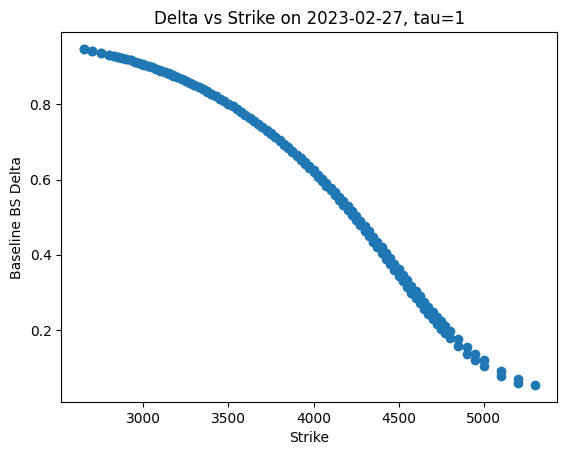

          vol           SSE
0    0.500000  78463.311429
1    0.895833  48647.293230
2    1.291667  34084.757015
3    1.687500  27971.403225
4    2.083333  25773.182035
5    2.479167  25449.592197
6    2.875000  26098.493134
7    3.270833  27297.991573
8    3.666667  28837.038501
9    4.062500  30602.768911
10   4.458333  32530.704560
11   4.854167  34581.447100
12   5.250000  36729.197103
13   5.645833  38955.846498
14   6.041667  41247.825907
15   6.437500  43594.370174
16   6.833333  45986.539042
17   7.229167  48416.651118
18   7.625000  50877.948965
19   8.020833  53364.395589
20   8.416667  55870.546492
21   8.812500  58391.465539
22   9.208333  60922.666354
23   9.604167  63460.068655
24  10.000000  65999.963387


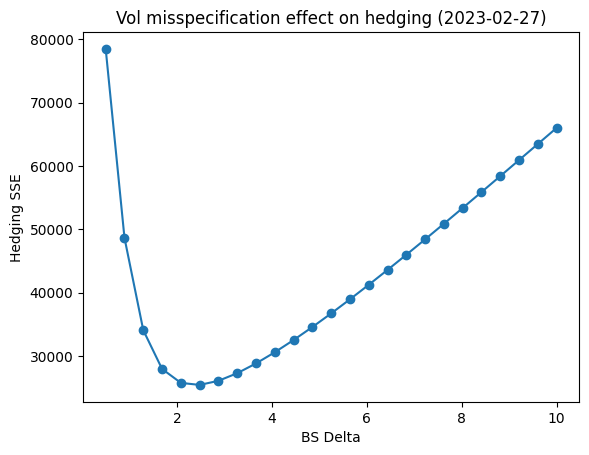

In [11]:
# compute residuals
def res(delta):
    return opt2["dVt"]-delta*opt2["dSt"]

# vendor delta
opt2["eps_vendor"] = res(opt2["delta_vendor"])

# BS delta
opt2["eps_bs"] = res(opt2["delta_bs"])

# filter using BS delta
opt_filtered = opt2.copy()
print("Initial rows:", len(opt_filtered))

opt_filtered = opt_filtered[opt_filtered["delta_bs"] > 0.05]
print("After delta > 0.05 filter:", len(opt_filtered))

opt_filtered = opt_filtered[opt_filtered["delta_bs"] < 0.95]
print("After delta < 0.95 filter:", len(opt_filtered))

opt_filtered["D_t"] = (opt_filtered["exdate"] - opt_filtered["date"]).dt.days
opt_filtered = opt_filtered[opt_filtered["D_t"] > 14]
print("After D_t > 14:", len(opt_filtered))

# SSE of BS delta
SSE = np.sum(res(opt_filtered["delta_bs"])**2)

## required reporting

# summary
print("Summary epsilon using vendor delta \n",opt2["eps_vendor"].describe())
print("Summary epsilon using BS delta \n",opt2["eps_bs"].describe())

# baseline SSE delta BS after filtering
print("Baseline SSE after filtering:", SSE)

# one plot
chosen_date = pd.Timestamp("2023-02-27")
print("Chosen date:", chosen_date)

tau_target = 1
tol = 1/12

slice_df = opt_filtered[
    (opt_filtered["date"] == chosen_date) &
    (abs(opt_filtered["tau_safe"] - tau_target) < tol)
]

plt.scatter(slice_df["strike_price"], slice_df["delta_bs"])
plt.xlabel("Strike")
plt.ylabel("Baseline BS Delta")
plt.title(f"Delta vs Strike on {chosen_date.date()}, tau={tau_target}")
plt.show()

# study
day_df = opt_filtered[opt_filtered["date"] == chosen_date].copy()

grid = np.linspace(0.5, 10, 25)

S = day_df["St"].to_numpy(float)
K = day_df["strike_price"].to_numpy(float)
tau = day_df["tau_safe"].to_numpy(float)
sigma_mkt = day_df["impl_volatility"].to_numpy(float)
is_call = (day_df["cp_flag"].astype(str).str.upper().to_numpy() == "C")

dV = day_df["dVt"].to_numpy(float)
dS = day_df["dSt"].to_numpy(float)

SSE_list = []

for lam in grid:
    sigma = sigma_mkt * lam

    # BS d1 with fixed r,q
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    delta = np.where(is_call, norm.cdf(d1), norm.cdf(d1) - 1.0)

    eps = dV - delta * dS
    SSE = np.sum(eps**2)
    SSE_list.append(SSE)

SSE_list = np.array(SSE_list)

print(pd.DataFrame({"vol": grid, "SSE": SSE_list}))

plt.plot(grid, SSE_list, marker="o")
plt.xlabel("BS Delta")
plt.ylabel("Hedging SSE")
plt.title("Vol misspecification effect on hedging (2023-02-27)")
plt.show()


# NEED EXERCISE 2



(e)

In [12]:
# 9 moneyness buckets
delta_edges = np.linspace(0.05, 0.95, 10)  
opt_filtered["bucket_delta"] = pd.cut(
    opt_filtered["delta_bs"],
    bins=delta_edges,
    include_lowest=False,  
    right=True              
)

# 7 maturity buckets
Dt_min = opt_filtered["D_t"].min()
Dt_max = opt_filtered["D_t"].max()

Dt_edges = np.linspace(Dt_min, Dt_max, 8)  
opt_filtered["bucket_Dt"] = pd.cut(
    opt_filtered["D_t"],
    bins=Dt_edges,
    include_lowest=True,
    right=True
)

bucket_counts = opt_filtered.groupby(["bucket_delta", "bucket_Dt"]).size()

print("Non-empty buckets:", bucket_counts.shape[0])
print("Total observations:", bucket_counts.sum())

Non-empty buckets: 63
Total observations: 86008


C:\Users\danis\AppData\Local\Temp\ipykernel_24996\2196900049.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_counts = opt_filtered.groupby(["bucket_delta", "bucket_Dt"]).size()


(f)

Total SSE (BS): 1085247.2292204355
Total MSE (BS): 12.617980062557384


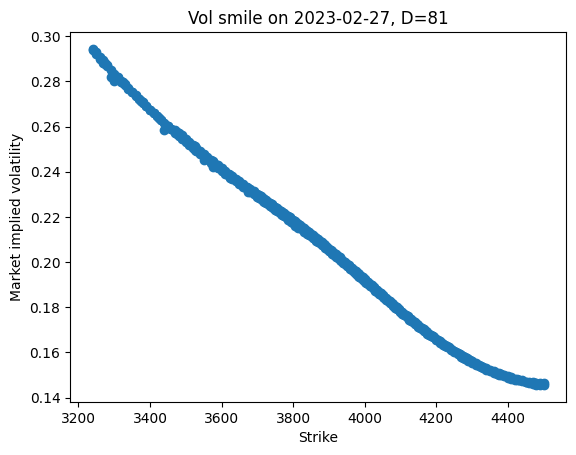

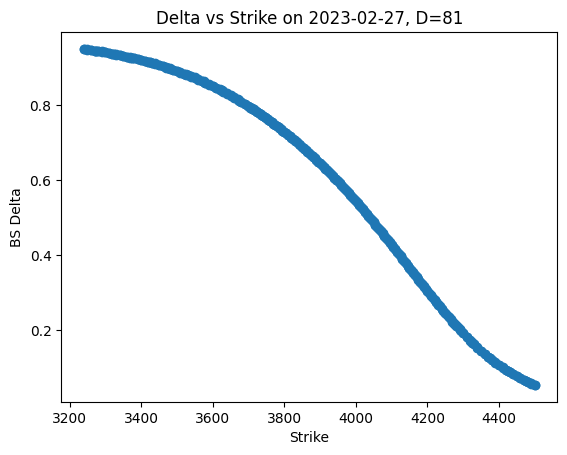

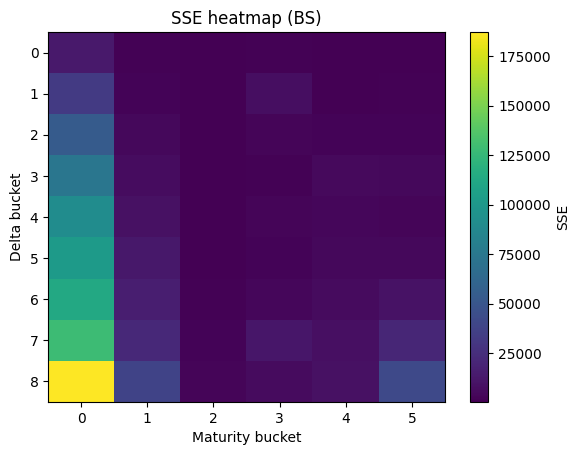

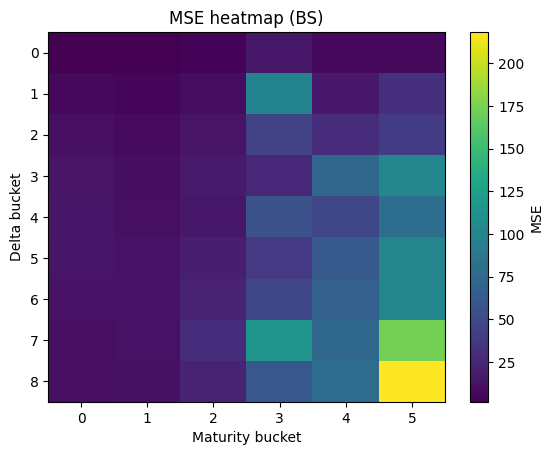

In [13]:
# residuals
opt_filtered["eps_bs"] = opt_filtered["dVt"] - opt_filtered["delta_bs"] * opt_filtered["dSt"]

# total SSE
SSE_total = (opt_filtered["eps_bs"]**2).sum()
print("Total SSE (BS):", SSE_total)

# total MSE
MSE_total = (opt_filtered["eps_bs"]**2).mean()
print("Total MSE (BS):", MSE_total)

# smile plot
D_target = opt_filtered[opt_filtered["date"] == chosen_date]["D_t"].mode()[0]

slice_df = opt_filtered[
    (opt_filtered["date"] == chosen_date) &
    (opt_filtered["D_t"] == D_target)
]

plt.scatter(slice_df["strike_price"], slice_df["impl_volatility"])
plt.xlabel("Strike")
plt.ylabel("Market implied volatility")
plt.title(f"Vol smile on {chosen_date.date()}, D={D_target}")
plt.show()

# delta plot
plt.scatter(slice_df["strike_price"], slice_df["delta_bs"])
plt.xlabel("Strike")
plt.ylabel("BS Delta")
plt.title(f"Delta vs Strike on {chosen_date.date()}, D={D_target}")
plt.show()

# heat maps
bucket_stats = opt_filtered.groupby(
    ["bucket_delta", "bucket_Dt"],
    observed=True
).agg(
    SSE=("eps_bs", lambda x: np.sum(x**2)),
    MSE=("eps_bs", lambda x: np.mean(x**2))
)

SSE_matrix = bucket_stats["SSE"].unstack()
MSE_matrix = bucket_stats["MSE"].unstack()

plt.imshow(SSE_matrix, aspect="auto")
plt.colorbar(label="SSE")
plt.title("SSE heatmap (BS)")
plt.xlabel("Maturity bucket")
plt.ylabel("Delta bucket")
plt.show()

plt.imshow(MSE_matrix, aspect="auto")
plt.colorbar(label="MSE")
plt.title("MSE heatmap (BS)")
plt.xlabel("Maturity bucket")
plt.ylabel("Delta bucket")
plt.show()


Step 7

(a)

In [14]:

full_index = pd.MultiIndex.from_product(
    [opt_filtered["bucket_delta"].cat.categories, opt_filtered["bucket_Dt"].cat.categories],
    names=["bucket_delta", "bucket_Dt"]
)
bucket_stats = bucket_stats.reindex(full_index)

# fill empty buckets
bucket_stats["SSE"] = bucket_stats["SSE"].fillna(0.0)
bucket_stats["MSE"] = bucket_stats["MSE"].fillna(0.0)

bucket_long = bucket_stats.reset_index()
print("bucket_long shape:", bucket_long.shape)  

# make scoreboard
bucket_long.to_csv("HedgingScoreboard.csv", index=False)




bucket_long shape: (63, 4)
